**기본 세팅**

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from IPython.display import Image

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

# 1. 정확도(Accuracy)

정확도는 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표로 직관적으로 모델 예측 성능을 평가 할 수 있다.

하지만 이진 분류의 경우 데이터에 따라 ML 모델의 성능을 왜곡할 수 있다.

- 정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수

## 1.1 타이타닉 예제

**데이터 편집 함수**

In [3]:
from sklearn.preprocessing import LabelEncoder

# Null 처리
def t_fillna(df):
    df["Age"].fillna(df.Age.mean(), inplace = True)
    df["Cabin"].fillna( "N", inplace = True)
    df["Embarked"].fillna( "N", inplace = True)
    df["Fare"].fillna(0, inplace = True) # Train에서 결측은 없었음
    return df

# 머신러닝 알고리즘에 불필요한 변수 제거
def t_drop_features(df):
    df.drop(["PassengerId", "Name", "Ticket"], axis=1, inplace=True)
    return df

# 레이블 인코딩 처리
def t_cat_encoding(df):
    df["Cabin"] = df["Cabin"].str[:1]
    
    features = ["Cabin", "Sex", "Embarked"]
    
    for f in features:
        le = LabelEncoder()
        le = le.fit(df[f])
        df[f] = le.transform(df[f])
    return df

# 나이 그룹 변수
def t_age_cat(df):
    bins = [np.min(titanic_df.Age), 5, 12, 18, 25, 35, 60, np.max(titanic_df.Age)]
    labels = ["Baby", "Child", "Teenager", "Student", " Young Adult", "Adult", "Elderly"]
    
    df["Age_cat"] = pd.cut(df["Age"], bins, labels=labels)
    return df

def t_transform_features(df, age_add=False):
    t_fillna(df)
    t_drop_features(df)
    t_cat_encoding(df)
    
    if age_add == True:
        t_age_cat(df)
        
    return df

- Chapter2에서 정의한 타이타닉 데이터 편집함수를 사용

**사용자 정의 Estimator**

In [4]:
from sklearn.base import BaseEstimator

#
class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    
    # predict() 메서드는 단순히 Sex가 1이면 0, 그렇지 않으면 1로 예측
    def predict(self, X):
        pred = np.zeros( (X.shape[0],1))
        
        for i in range(X.shape[0]):
            if X.Sex.iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
                
        return pred

- `BaseEstimator`는 개발자가 직접 Estimator를 생성할 수 있다.


- 여기선 `fit()`은 아무 학습을 하지 않고 `predict()`는 단순히 Sex에 따라 예측하게 설정하였다.

**학습/예측/평가**

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 데이터 로드, 가공, 학습/검증 데이터 분리
titanic_df = pd.read_csv("./titanic_train.csv")
titanic_df = t_transform_features(titanic_df)

titanic_X = titanic_df.drop("Survived", axis=1)
titanic_y = titanic_df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_y, test_size=0.2, random_state=1017)

# 사용자 정의 Estimator로 학습/예측/평가
my_clf = MyDummyClassifier()
my_clf.fit(X_train,y_train)

my_pred = my_clf.predict(X_test)

acc = accuracy_score(y_test,my_pred)
print(f"Dummy Classifier의 정확도: {acc:.4f}")

Dummy Classifier의 정확도: 0.7598


- 아무것도 학습하지 않고 단순한 알고리즘에 따라 예측하였음에도 비교적 높은 정확도가 나타났다.


- 따라서 정확도를 ML 성능 평가 지표로 사용할 때에는 신중해야한다.


- 특히 불균형한 데이터 분포에서 평가 지표로서 적합하지 않다. 

    만약 0이 90개, 1이 10개인 데이터가 있다면 무조건 0으로 예측하는 ML 모델도 정확도가 90%가 된다.

## 1.2 MNIST 예제

원래 MNIST 데이터는 0부터 9까지의 숫자 이미지의 픽셀 정보를 가지고 있으며 이를 기반으로 숫자 Digit을 예측하는데 사용한다.

여기선 숫자 7만 True 나머지는 False로 변경하여 불균형한 데이터 분포로 만들 것이다.

**사용자 정의 Estimator**

In [6]:
class MyFakeClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y):
        pass
    
    # 예측값은 모두 0으로 반환
    def predict(self, X):
        return np.zeros( (X.shape[0],1))

**데이터 분포 확인**

In [7]:
from sklearn.datasets import load_digits

# 데이터 로드, y는 7일 경우 1 나머지는 모두 0으로 설정
digits = load_digits()
digits_x = digits.data
digits_y = (digits.target == 7).astype(int)

# 학습/검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(digits_x, digits_y, random_state=1017)

# 불균형한 데이터 분포도 확인
print("# 검증 데이터 크기:", y_test.shape[0])
print("# 검증 데이터 분포\n", pd.Series(y_test).value_counts())

# 검증 데이터 크기: 450
# 검증 데이터 분포
 0    413
1     37
dtype: int64


- 검증 데이터의 대부분이 0으로 분류되어 있다.

**학습/예측/평가**

In [8]:
fake_clf = MyFakeClassifier()
fake_clf.fit(X_train,y_train)

fake_pred = fake_clf.predict(X_test)

acc = accuracy_score(y_test,fake_pred)
print(f"Dummy Classifier의 정확도: {acc:.4f}")

Dummy Classifier의 정확도: 0.9178


- 학습 데이터에 상관없이 모두 0으로 예측하였는데 정확도가 91.78%로 매우 높다.


- 즉, 불균형한 데이터 세트에선 성능 평가 지표로 정확도를 사용하면 안된다.

# 2. 오차 행렬

$% ![Error_Matrix](./img/Error_Matrix.png)$
<img src="./img/Error_Matrix.png" height="100px" width="500px" align="left">

- TN: Negative값 0으로 예측했고 실제 값 역시 Negative값 0


- FP: Positive값 1로 예측했고 실제 값은 Negative값 0


- FN: Negative값 0으로 예측했고 실제 값은 Positive값 1


- TP: Positive값 1로 예측했고 실제 값 역시 Positive값 1

- 오차 행렬을 기준으로 정확도는 다음과 같이 정의 할 수 있다.


$$\text{Accuracy} = \dfrac{(\text{TN + TP})}{(\text{TN + FP + FN + TP})}$$

**Confusion Matrix**

In [9]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fake_pred)

array([[413,   0],
       [ 37,   0]], dtype=int64)

- `confusion_matrix`를 이용해 오차행렬을 확인 할 수 있다.

# 3. 정밀도와 재현율

- 정밀도(Precision)는 양성예측도로서 양성으로 예측한 데이터 중 실제 양성의 비율로 다음과 같이 정의 할 수 있다.


$$\text{Precision} = \dfrac{\text{TP}}{(\text{FP + TP})}$$

- 재현율(Recall) 혹은 민감도(Sensitivity)는 실제 양성을 양성으로 예측할 확률로 다음과 같이 정의 할 수 있다.


$$\text{Recall} = \dfrac{\text{TP}}{(\text{FN +TP})}$$

- 추가적으로 특이도(Specificity)는 실제 음성을 음성으로 예측할 확률로 다음과 같이 정의 할 수 있다.


$$\text{Specificity} = \dfrac{\text{TN}}{(\text{FP +TN})}$$

**정확도/정밀도/재현율 함수**

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
   
    print("오차 행렬")
    print(confusion)
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}")

**Logistic Regression**

In [11]:
from sklearn.linear_model import LogisticRegression

# 데이터 로드, 가공, 학습/검증 데이터 분리
titanic_df = pd.read_csv("./titanic_train.csv")
titanic_df = t_transform_features(titanic_df)

titanic_X = titanic_df.drop("Survived", axis=1)
titanic_y = titanic_df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_y, test_size=0.2, random_state=1017)

# 학습/예측/평가
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)

lr_pred = lr_clf.predict(X_test)

get_clf_eval(y_test,lr_pred)

오차 행렬
[[90 17]
 [20 52]]
정확도: 0.7933, 정밀도: 0.7536, 재현율: 0.7222


## 3.1 정밀도/재현율 트레이드오프

분류하려는 업무 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 임계값(threshold)을 조정하여 수치를 높일 수 있다.

- 기본적으로 데이터를 입력해서 0일 확률이 70%, 1일 확률이 30%이면 0으로 분류하게 된다.


- 즉, 50%를 기준으로 예측 분류를 진행하게 되는데 임계값을 20%로 조정한다면 20%보다 높으면 1로 분류하게 된다.

하지만 정밀도와 재현율은 상호 보완적인 지표이기 때문에 어느한쪽을 높인다면 다른 하나의 수치는 떨어지기 싶다.

**예측 확률**

In [12]:
lr_pred_proba = lr_clf.predict_proba(X_test)
lr_pred = lr_clf.predict(X_test).reshape(-1,1)

temp = pd.DataFrame( np.concatenate([lr_pred_proba,lr_pred], axis=1) )
temp.columns = ["Negative P", "Positive P", "predict"]
temp.head()

,Negative P,Positive P,predict
0,0.357806,0.642194,1.0
1,0.327997,0.672003,1.0
2,0.262400,0.737600,1.0
3,0.276415,0.723585,1.0
4,0.925354,0.074646,0.0


- `predict_proba`를 이용하여 Negative, Positive 확률을 확인 가능하다.

**Binarizer**

In [13]:
from sklearn.preprocessing import Binarizer

X = [[1,-1],
     [0.3,0.4]]

# Binarizer 객체 생성
binarizer = Binarizer(threshold = 0.3)

# fit, transform
binarizer.fit(X)
print(binarizer.transform(X))

[[1. 0.]
 [0. 1.]]


- `Binarizer`는 threshold보다 작거나 같으면 0, 크면 1을 반환한다.

In [14]:
# threshold 설정
my_thres = 0.5

# Positive 확률
lr_pred_proba_po = lr_pred_proba[:,1].reshape(-1,1)

# Binarizer
binarizer = Binarizer(threshold = my_thres)
binarizer.fit(lr_pred_proba_po)
my_pred = binarizer.transform(lr_pred_proba_po)

get_clf_eval(y_test,my_pred)

오차 행렬
[[90 17]
 [20 52]]
정확도: 0.7933, 정밀도: 0.7536, 재현율: 0.7222


- threshold를 0.5로 설정하여 기본 세팅값과 동일한 결과가 출력되는 것을 확인할 수 있다.

In [15]:
# threshold 설정
my_thres = 0.3

# Positive 확률
lr_pred_proba_po = lr_pred_proba[:,1].reshape(-1,1)

# Binarizer
binarizer = Binarizer(threshold = my_thres)
binarizer.fit(lr_pred_proba_po)
my_pred = binarizer.transform(lr_pred_proba_po)

get_clf_eval(y_test,my_pred)

오차 행렬
[[78 29]
 [ 9 63]]
정확도: 0.7877, 정밀도: 0.6848, 재현율: 0.8750


- threshold를 0.3으로 설정하여 Positive로 예측한 경우가 많아졌다. (FP,TP 증가 / FN,TN 감소)


- 이에 따라 정밀도는 떨어지고 재현율은 증가한 것을 확인 할 수 있다.

**Threshold에 따른 평가지표 함수**

In [16]:
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval_thres(y_test, pred_po, threshold, f1_show=False, auc_show=False):
    eval_df = pd.DataFrame()
    
    for thres in threshold:
        # threshold에 따른 예측 분류 값
        binarizer = Binarizer(threshold = thres)
        binarizer.fit(pred_po)
        thres_pred = binarizer.transform(pred_po)
        
        # 평가지표 - F1 스코어는 목차 4, roc는 목차 5에서 확인
        accuracy = accuracy_score(y_test, thres_pred)
        precision = precision_score(y_test, thres_pred)
        recall = recall_score(y_test, thres_pred)
        f1 = f1_score(y_test, thres_pred)
        auc = roc_auc_score(y_test, pred_po)
        
        # 데이터 프레임 형태
        eval_lst = np.array([accuracy, precision, recall, f1, auc]).reshape(-1,1)
        temp = pd.DataFrame(eval_lst, columns=[thres], index = ["정확도", "정밀도", "재현율", "F1스코어", "AUC"])
        eval_df = pd.concat([eval_df,temp], axis=1)
        
    eval_df.columns.names = ["임계값"]
    
    if f1_show == False:
        eval_df.drop("F1스코어", axis=0, inplace=True)
        
    if auc_show == False:
        eval_df.drop("AUC", axis=0, inplace=True)
        
    return round(eval_df,4)

In [17]:
# threshold 리스트
thres_lst = [0.4, 0.45, 0.5, 0.55, 0.6]

# Positive 확률
lr_pred_proba_po = lr_pred_proba[:,1].reshape(-1,1)

# threshold에 따른 평가지표
get_clf_eval_thres(y_test, lr_pred_proba_po, thres_lst)

임계값,0.40,0.45,0.50,0.55,0.60
정확도,0.7933,0.7989,0.7933,0.7933,0.7821
정밀도,0.7273,0.7500,0.7536,0.7778,0.8000
재현율,0.7778,0.7500,0.7222,0.6806,0.6111


- threshold별로 평가 지표를 확인하였을 때, 만약 재현율을 높이고 싶다면 threhold는 0.45가 좋아보인다.


- threshold가 0.45인 경우 원래 기준인 0.5에 비해서 정확도는 증가하였고, 정밀도도 큰 차이가 없다.

**precision_recall_curve**

In [18]:
from sklearn.metrics import precision_recall_curve

# Positive 확률
lr_pred_proba_po = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)

# precision_recall_curve(실제 y, Positve로 예측할 확률)
precisions, recalls, thresholds = precision_recall_curve(y_test, lr_pred_proba_po)
print("임계값 배열:", thresholds.shape)

# 일부 threshold만 사용
thr_idx = np.arange(0, thresholds.shape[0], 17) # 17step으로 10개의 threshold 사용

print("샘플 임계값:", np.round(thresholds[thr_idx],2))
print("샘플 임계값별 정밀도:", np.round(precisions[thr_idx],3))
print("샘플 임계값별 재현율:", np.round(recalls[thr_idx],3))

임계값 배열: (163,)
샘플 임계값: [0.07 0.1  0.12 0.14 0.23 0.37 0.58 0.66 0.72 0.86]
샘플 임계값별 정밀도: [0.426 0.454 0.5   0.574 0.677 0.722 0.79  0.818 0.889 1.   ]
샘플 임계값별 재현율: [1.    0.958 0.917 0.917 0.903 0.792 0.681 0.5   0.333 0.139]


- `precision_recall_curve`를 이용하여 threshold별 정밀도, 재현율을 쉽게 구할 수 있다.


- threshold가 증가함에 따라 정밀도는 증가하는 반면 재현율은 감소하는 것이 확인 된다.

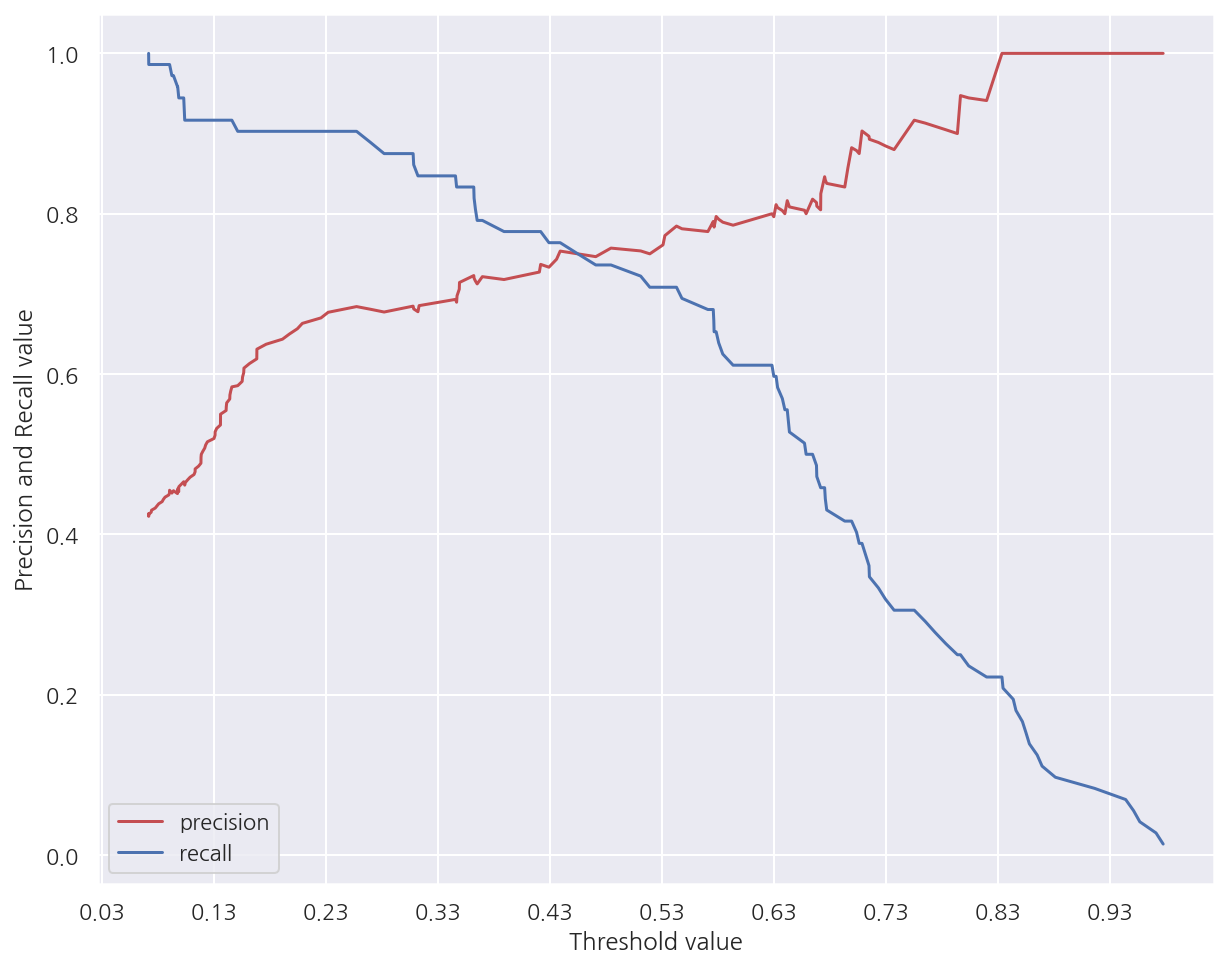

In [19]:
import matplotlib.ticker as ticker

def precision_recall_curve_plot(y_test, pred_proba_po):
    # precision_recall_curve(실제 y, Positve로 예측할 확률)
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_po)

    # plot
    # y축인 precisions와 recalls의 갯수 = threshold 갯수 + 1 이어서 x,y 갯수를 동일하게 맞춰줌
    thres_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[:thres_boundary], "r", label="precision")
    plt.plot(thresholds, recalls[:thres_boundary], label="recall")
    
    # x축 스케일 0.1 단위로 조정
    start, end = plt.xlim()
    plt.xticks( np.round( np.arange(start, end, 0.1), 2))

    # 라벨링
    plt.xlabel("Threshold value"), plt.ylabel("Precision and Recall value")
    plt.legend()

    plt.show()
    
# Positive 확률
lr_pred_proba_po = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)

precision_recall_curve_plot(y_test, lr_pred_proba_po)

- 그림으로 다시 한번 threshold가 증가함에 따라 정밀도는 증가하는 반면 재현율은 감소하는 것을 확인 할 수 있다.


- threshold가 0.45 부근에서 정밀도와 재현율이 비슷한 값을 가지는 것을 확인 할수 있다.

## 3.2 정밀도와 재현율의 맹점

정밀도(Precision)는 양성으로 예측한 데이터 중 실제 양성의 비율이므로 정밀도를 높이려면

- 엄격하게 확실히 양성일때만 양성으로 예측하면 된다. (threshold를 높인다.)


- 이 경우 실제 양성이 1,000명인데 1명만을 양성으로 예측해서 양성이면 정밀도는 100%가 된다.

재현율(Recall)은 실제 양성을 양성으로 예측할 확률이므로 재현율을 높이려면


- 모두 양성으로 예측하면 된다. (threshold를 낮춘다.)


- 이 경우 실제 양성이 10명인데 1,000명을 양성으로 예측했어도 10명이 포함되어 있으므로 재현율은 100%가 된다.

# 4. F1 스코어

F1 스코어는 앞서 정밀도와 재현율의 맹점을 보완하는 지표로 다음과 같이 정의된다.

$$\text{F1} = \dfrac{2}{\text{recall}^{-1} + \text{precision}^{-1}} = 2\cdot\dfrac{\text{precision} \cdot \text{recall}}{\text{precision}+\text{recall}}$$

- F1 스코어는 정밀도와 재현율이 어느 한쪽으로 치우치지 않았을 때 상대적으로 높은 값을 가진다.

In [20]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test,lr_pred)
print(f"F1 스코어: {f1:.4f}")

F1 스코어: 0.7376


- 앞서 타이타닉 예제에서 F1 스코어이다. (threshold는 기본 0.5)

In [21]:
# threshold 리스트
thres_lst = [0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8]

# Positive 확률
lr_pred_proba_po = lr_pred_proba[:,1].reshape(-1,1)

# threshold에 따른 평가지표
get_clf_eval_thres(y_test, lr_pred_proba_po, thres_lst, f1_show=True)

임계값,0.20,0.30,0.40,0.45,0.50,0.55,0.60,0.70,0.80
정확도,0.7709,0.7877,0.7933,0.7989,0.7933,0.7933,0.7821,0.7374,0.6872
정밀도,0.6566,0.6848,0.7273,0.7500,0.7536,0.7778,0.8000,0.8788,0.9444
재현율,0.9028,0.8750,0.7778,0.7500,0.7222,0.6806,0.6111,0.4028,0.2361
F1스코어,0.7602,0.7683,0.7517,0.7500,0.7376,0.7259,0.6929,0.5524,0.3778


- F1 스코어는 threshold가 0.3일때 가장 높으나 정밀도가 크게 감소되어 있어 유의하여야 한다.

# 5. ROC 곡선과 AUC

ROC 곡선은 x축으로 FPR = 1 - 특이도, y축으로 TPR = 민감도 로 나타낸 곡선 그림이다.

AUC는 ROC 곡선 밑의 면적으로 1에 가까울수록 좋은 수치이다.

**roc_curve**

In [22]:
from sklearn.metrics import roc_curve

# Positive 확률
lr_pred_proba_po = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)

# FPR(1-특이도), TPR(재현율=민감도), Threshold
# precision_recall_curve와는 다르게 임계값이 큰 값부터 작은 값 순서이다.
FPRs, TPRs, thresholds = roc_curve(y_test, lr_pred_proba_po)
print("임계값 배열:", thresholds.shape)

# 일부 threshold만 사용
# roc_curve에서 thresholds[0]은 max(예측확률)+1로 임의 설정된다. 이를 제외하기 위해 np.arange는 1부터 시작
thr_idx = np.arange(1, thresholds.shape[0], 10)

print("샘플 임계값:", np.round(thresholds[thr_idx],2))
print("샘플 임계값별 FPR:", np.round(FPRs[thr_idx],3))
print("샘플 임계값별 TPR:", np.round(TPRs[thr_idx],3))

임계값 배열: (60,)
샘플 임계값: [0.98 0.69 0.63 0.44 0.31 0.1 ]
샘플 임계값별 FPR: [0.    0.056 0.103 0.168 0.271 0.766]
샘플 임계값별 TPR: [0.014 0.417 0.611 0.764 0.875 0.944]


- `roc_curve`를 이용하여 threshold별 FPR, TTR을 쉽게 구할 수 있다.


- `precision_recall_curve`와는 다르게 threshold가 큰 값부터 점차 작아지는 순서로 나타난다.

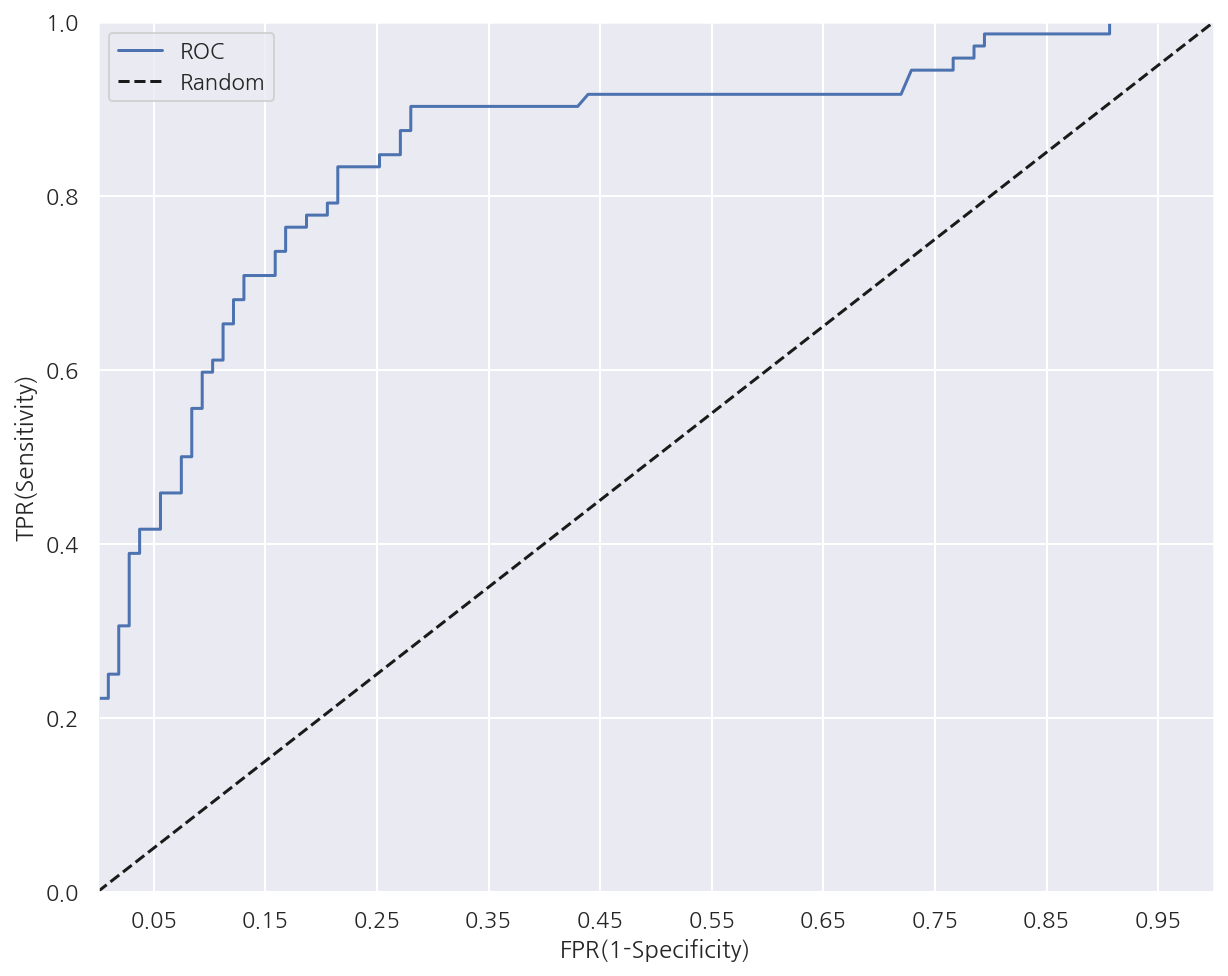

In [23]:
def roc_curve_plot(y_test, pred_proba_po):
    # FPR(1-특이도), TPR(재현율=민감도), Threshold
    # precision_recall_curve와는 다르게 임계값이 큰 값부터 작은 값 순서이다.
    FPRs, TPRs, thresholds = roc_curve(y_test, pred_proba_po)
    
    # ROC plot
    plt.plot(FPRs, TPRs, label ="ROC")
        
    # 45도 직선
    plt.plot( [0,1], [0,1], "k--", label="Random")
    
    # x축 스케일 0.1 단위로 조정
    start, end = plt.xlim()
    plt.xticks( np.round( np.arange(start, end, 0.1), 2))
    
    # 기타 옵션
    plt.xlim(0,1), plt.ylim(0,1)
    plt.xlabel("FPR(1-Specificity)"), plt.ylabel("TPR(Sensitivity)")
    plt.legend()

    plt.show()
    
# Positive 확률
lr_pred_proba_po = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)

roc_curve_plot(y_test, lr_pred_proba_po)

- ROC 곡선 자체는 FPR과 TPR의 변화를 보는데 이용하며 분류 성능 지표로는 AUC를 사용한다.


- AUC는 곡선이 가운데 직선을 기준으로 왼쪽으로 멀수록, 상단으로 멀수록 높아진다.


- 즉, FPR이 낮을 때(특이도가 높을 때) TPR(민감도)가 높을수록 AUC값이 좋아지는 것으로 특이도와 민감도가 모두 좋을 때 높아지는 개념이다.

**AUC**

In [24]:
from sklearn.metrics import roc_auc_score

# Positive 확률
lr_pred_proba_po = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)

# AUC
roc_score = roc_auc_score(y_test, lr_pred_proba_po)
print(f"AUC 값: {roc_score:.4f}")

AUC 값: 0.8546


- 다른 평가 지표는 예측 분류: `predict`값을 기입하였지만 AUC는 `predict_proba`의 양성 확률을 기입하여야 한다.


- 확률로 입력이 되어야 threshold별 FPR, TPR등이 계산되어 AUC가 출력 될 것으로 이해하면 좋을 듯 하다.

**평가지표 함수 - 최종**

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba_po=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba_po)
   
    print("오차 행렬")
    print(confusion)
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

# 6. 피마 인디언 당뇨병 예측

## 6.1 데이터 구조

- Pregnancies: 임신 횟수
  
  
- Glucose: 포도당 부하 검사 수치


- BloodPressure: 혈압


- SkinThickness: 팔 삼두근 뒤쪽의 피하지방 측정값


- Insulin: 혈청 인슐린


- BMI: 체질량지수


- DiabetesPedigreeFunction: 당뇨 내력 가중치 값


- Age: 나이


- Outcome: 클래스 결정 값(0,1)

## 6.2 데이터 불러오기 및 편집

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('diabetes.csv')
diabetes_data.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [27]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


- 768개의 행, 9개의 열로 이루어져있으며 결측값은 없다.


- 모두 숫자형 변수로 문자형 의미를 가진 변수가 없으므로 인코딩은 필요 없어 보인다.

In [28]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- 데이터에 min값이 0인 변수가 많다.


- Glucose는 포도당 수치인데 min값이 0이 될 수 없다.

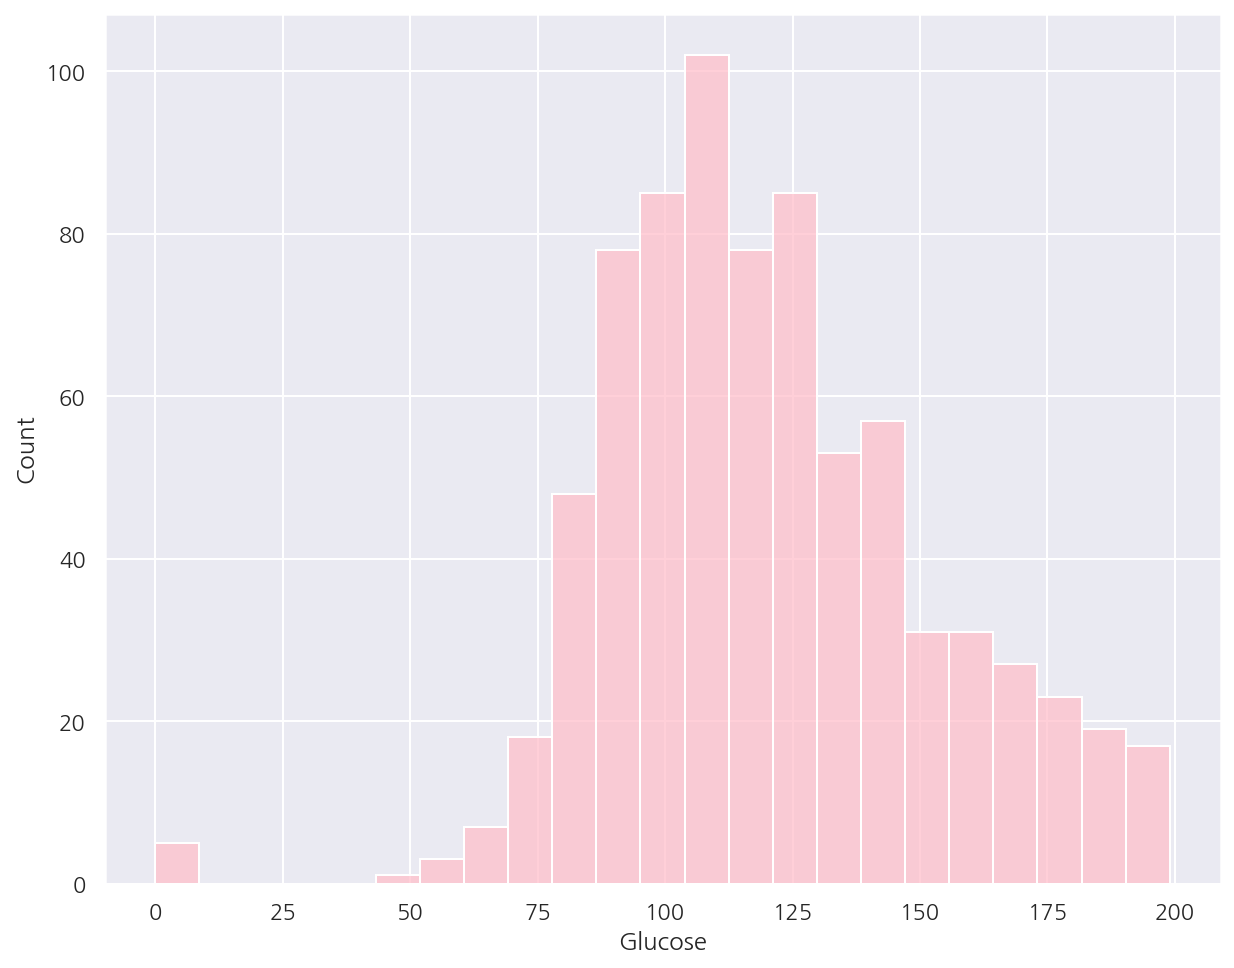

In [29]:
sns.histplot(data = diabetes_data, x = "Glucose", kde = False, color = "pink")
plt.show()

- Glucose 히스토그램을 확인하면 0 값이 일정량 존재하는 것을 알 수 있다.

In [30]:
# 0값 검사할 변수 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data.count()[0]

# 피처별 0값 비율
for feature in zero_features:
    zero_count = diabetes_data[feature].value_counts()[0]
    zero_rate = 100 * zero_count / total_count
    print(f"{feature}의 0 건수: {zero_count}, 퍼센트: {zero_rate:.2f}%")

Glucose의 0 건수: 5, 퍼센트: 0.65%
BloodPressure의 0 건수: 35, 퍼센트: 4.56%
SkinThickness의 0 건수: 227, 퍼센트: 29.56%
Insulin의 0 건수: 374, 퍼센트: 48.70%
BMI의 0 건수: 11, 퍼센트: 1.43%


- SkinThickness, Insulin은 0값의 비율이 높아 데이터를 삭제하긴 무리가 있어 대체값이 필요해 보인다.

In [31]:
mean_zero_features = diabetes_data[zero_features].mean()

diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

- 0값을 각 변수의 평균값으로 대체 하였다.

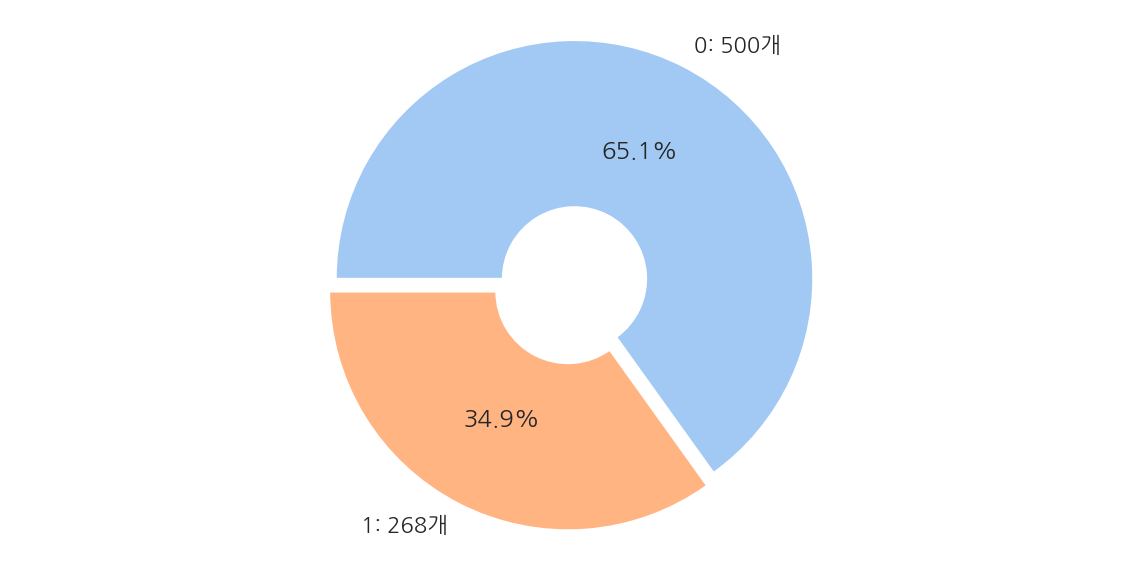

In [32]:
plt.figure(figsize=(10,5))

frequency = diabetes_data['Outcome'].value_counts()
label = [f"0: {frequency[0]}개", f"1: {frequency[1]}개"]

plt.pie(frequency,
    startangle = 180,
    counterclock = False,
    explode = [0.03] * 2,
    autopct = '%1.1f%%',
    labels = label,
    colors = sns.color_palette('pastel', 2),
    wedgeprops = dict(width=0.7)
  )


plt.axis('equal')
plt.show()

- 전체 768개 데이터 중 Negative가 500개(65.1%), Positive가 268개(34.9%)로 이루어져 있다.


- Negative가 많으므로 정확도보다는 재현율에 초점을 맞춘다.

In [33]:
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.Outcome

# StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

- 다음 스텝에서 로지스틱 회귀분석을 진행할 것이다. 


- 로지스틱 회귀분석은 숫자형 데이터에 스케일링을 적용하는 것이 일반적으로 좋다.

## 6.3 성능 평가

**Logistic Regression**

In [34]:
# 학습/검증 데이터 분리 (데이터 분포에 맞게)
X_train, X_test, y_train, y_test= train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

# Logistic Regression 학습/예측/평가
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

pred = lr_clf.predict(X_test)
pred_proba_po = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)

get_clf_eval(y_test, pred, pred_proba_po)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC: 0.8433


**정밀도/재현율**

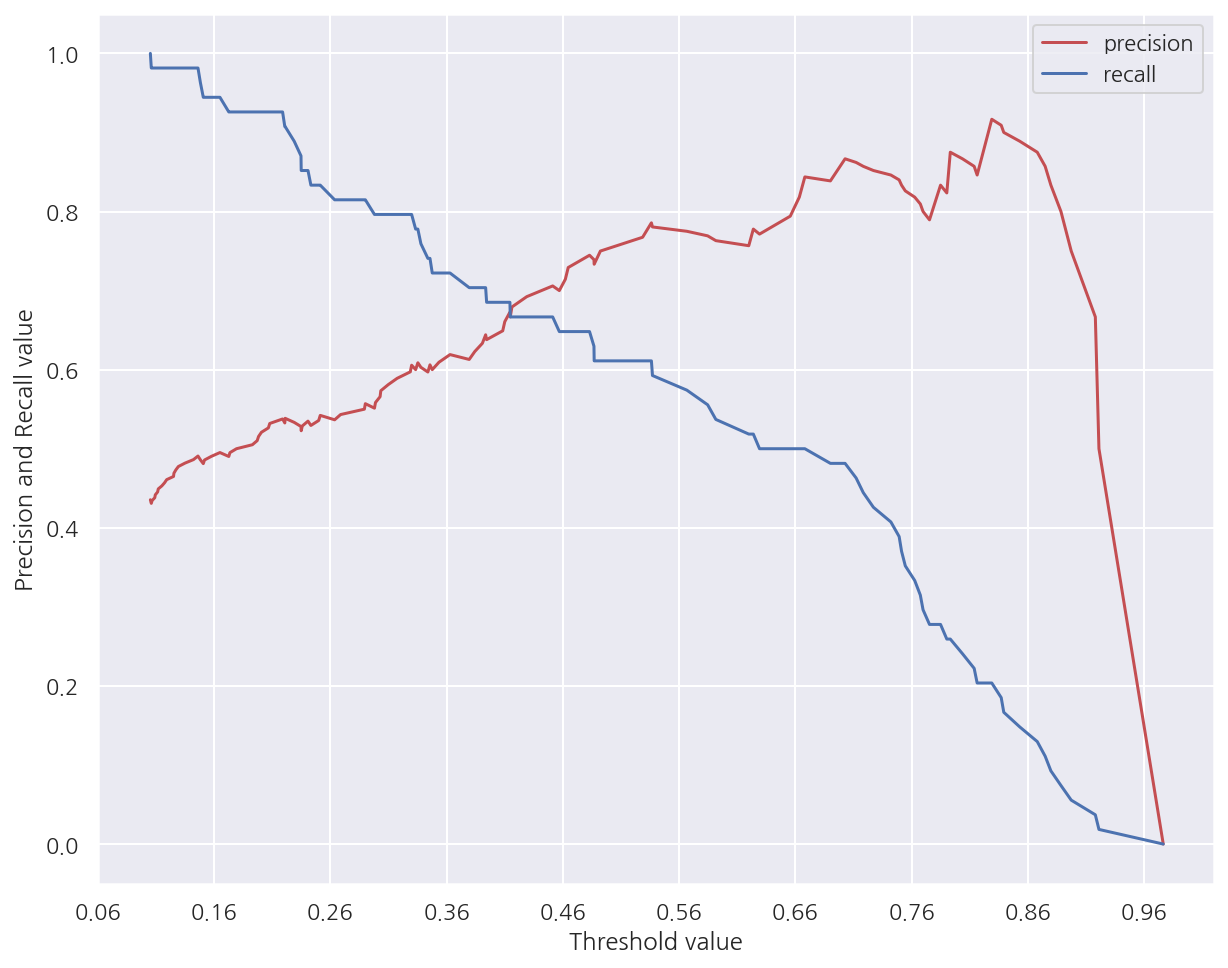

In [35]:
precision_recall_curve_plot(y_test, pred_proba_po)

- 그림을 보면 임계값이 대략 0.41 정도에 정밀도와 재현율이 균형이 맞는 것으로 보인다.


- 하지만 해당 임계값에서 두 지표 모두 낮은 수치로 나타난다.

**F1 스코어/AUC 추가**

In [36]:
# threshold 리스트
thres_lst = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.5]
get_clf_eval_thres(y_test, pred_proba_po, thres_lst, f1_show=True, auc_show=True)

임계값,0.30,0.33,0.36,0.39,0.42,0.45,0.48,0.50
정확도,0.7143,0.7403,0.7468,0.7532,0.7792,0.7857,0.7987,0.7987
정밀도,0.5658,0.6000,0.6190,0.6333,0.6923,0.7059,0.7447,0.7674
재현율,0.7963,0.7778,0.7222,0.7037,0.6667,0.6667,0.6481,0.6111
F1스코어,0.6615,0.6774,0.6667,0.6667,0.6792,0.6857,0.6931,0.6804
AUC,0.8433,0.8433,0.8433,0.8433,0.8433,0.8433,0.8433,0.8433


- 재현율을 높이는데 초점을 둔다면 threshod는 0.3일때 가장 좋아보이나 정밀도가 매우 낮아진다.


- threshold가 0.48이 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 높이므로 좋은 임계값으로 보인다.

In [37]:
binarizer = Binarizer(threshold = 0.48)
pred048 = binarizer.fit_transform(pred_proba_po)

get_clf_eval(y_test, pred048, pred_proba_po)

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1: 0.6931, AUC: 0.8433


- threshold가 0.48일때 오차행렬 및 앞서 구한 성능 평가 지표이다.